# PGAIML Capstone Project - Part 1: Vehicle Detection and Localization

This notebook implements an object detection model for autonomous vehicles, which can detect and localize vehicles in images using deep learning techniques.

## Problem Statement
Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time helps AV technology and makes ITS more intelligent in terms of vehicle tracking, vehicle counting, and road incident response.

## Objective
Develop an AI model using a deep learning framework that predicts the type of vehicle present in an image as well as localizes the vehicle by rectangular bounding box.

## 1. Setup and Environment Preparation

First, let's import all necessary libraries and set up our environment.

In [18]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions for documentation
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.10.0
OpenCV version: 4.11.0
NumPy version: 1.24.3
Pandas version: 2.0.3


### 1.1 Create Directory Structure

As per the project requirements, we need to create a parent folder for custom model training and child folders to store data.

In [19]:
# Define the base directory
BASE_DIR = os.path.dirname(os.getcwd())
print(f"Base directory: {BASE_DIR}")

# Create model training directory and subdirectories
MODEL_DIR = os.path.join(BASE_DIR, 'model_training')
TRAIN_DIR = os.path.join(MODEL_DIR, 'train')
VAL_DIR = os.path.join(MODEL_DIR, 'validation')
TEST_DIR = os.path.join(MODEL_DIR, 'test')
WEIGHTS_DIR = os.path.join(MODEL_DIR, 'weights')

# Create directories if they don't exist
for directory in [MODEL_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, WEIGHTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}")

# Define paths to data
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
LABELS_PATH = os.path.join(BASE_DIR, 'labels.csv')

print(f"\nImages directory: {IMAGES_DIR}")
print(f"Labels file: {LABELS_PATH}")

Base directory: /Users/c11595/PGAIML_Capstone
Created directory: /Users/c11595/PGAIML_Capstone/model_training
Created directory: /Users/c11595/PGAIML_Capstone/model_training/train
Created directory: /Users/c11595/PGAIML_Capstone/model_training/validation
Created directory: /Users/c11595/PGAIML_Capstone/model_training/test
Created directory: /Users/c11595/PGAIML_Capstone/model_training/weights

Images directory: /Users/c11595/PGAIML_Capstone/Images
Labels file: /Users/c11595/PGAIML_Capstone/labels.csv


## 2. Data Exploration and Preparation

Let's first explore the dataset to understand its structure and contents.

### 2.1 Explore Image Dataset

In [20]:
# List all image files
image_files = os.listdir(IMAGES_DIR)
image_files = [f for f in image_files if f.endswith('.jpg')]
print(f"Total number of images: {len(image_files)}")

# Display a few sample image names
print("\nSample image filenames:")
for i in range(min(5, len(image_files))):
    print(image_files[i])

Total number of images: 5626

Sample image filenames:
00003135.jpg
00004882.jpg
00005222.jpg
00003653.jpg
00005236.jpg


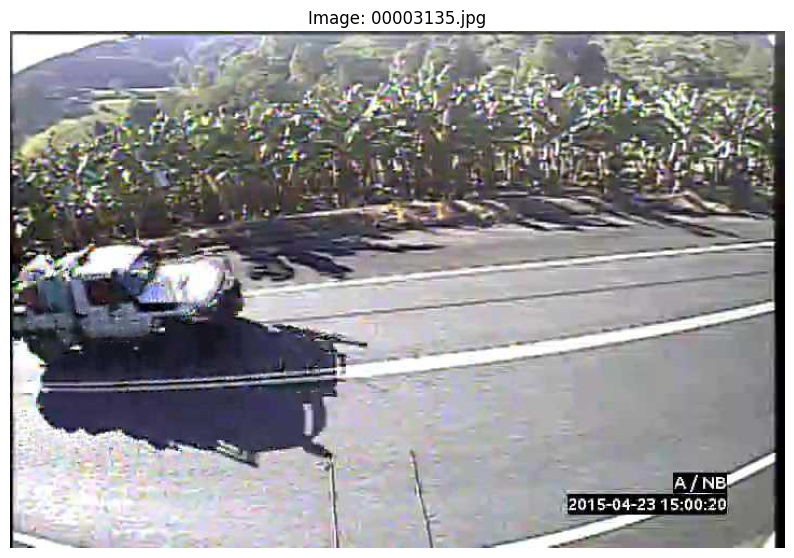

Image shape: (480, 720, 3)


In [21]:
# Load and display a sample image
def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.show()
    return img

# Display a sample image
sample_image_path = os.path.join(IMAGES_DIR, image_files[0])
sample_img = display_image(sample_image_path)
print(f"Image shape: {sample_img.shape}")

### 2.2 Explore Labels Dataset

In [22]:
# Load the labels CSV file
try:
    # Add proper column names since the CSV doesn't have headers
    labels_df = pd.read_csv(LABELS_PATH, header=None, 
                           names=['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max'])
    print(f"Labels dataframe shape: {labels_df.shape}")
    print("\nFirst few rows of the labels dataframe:")
    display(labels_df.head())
    
    # Check for missing values
    print("\nMissing values in each column:")
    display(labels_df.isnull().sum())
    
    # Get column information
    print("\nColumn information:")
    display(labels_df.info())
    
    # Check unique values for categorical columns
    print("\nUnique vehicle classes:")
    display(labels_df['class'].value_counts())
except Exception as e:
    print(f"Error loading labels file: {e}")
    print("We'll proceed assuming the labels file contains image IDs, bounding box coordinates, and class labels.")

Labels dataframe shape: (351548, 6)

First few rows of the labels dataframe:


,00000000,pickup_truck,213,34,255,50
0,0,car,194,78,273,122
1,0,car,155,27,183,35
2,0,articulated_truck,43,25,109,55
3,0,car,106,32,124,45
4,1,bus,205,155,568,314



Missing values in each column:


00000000        0
pickup_truck    0
213             0
34              0
255             0
50              0
dtype: int64


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351548 entries, 0 to 351547
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   00000000      351548 non-null  int64 
 1   pickup_truck  351548 non-null  object
 2   213           351548 non-null  int64 
 3   34            351548 non-null  int64 
 4   255           351548 non-null  int64 
 5   50            351548 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 16.1+ MB


None

### 2.3 Visualize Sample Images with Bounding Boxes

Let's visualize some sample images with their corresponding bounding boxes to better understand the data.

In [28]:
# Function to display image with bounding box
def display_image_with_bbox(image_id, bbox_data):
    # Assuming bbox_data contains [x_min, y_min, x_max, y_max, class_label]
    image_path = os.path.join(IMAGES_DIR, f"{image_id}.jpg")
    
    if not os.path.exists(image_path):
        # Try with different formatting of the image ID
        image_path = os.path.join(IMAGES_DIR, f"{int(image_id):08d}.jpg")
        if not os.path.exists(image_path):
            print(f"Image not found: {image_id}")
            return
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding box
    x_min, y_min, x_max, y_max = bbox_data[:4]
    class_label = bbox_data[4] if len(bbox_data) > 4 else 'Unknown'
    
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    cv2.putText(img, f"Class: {class_label}", (int(x_min), int(y_min) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)} with Bounding Box")
    plt.show()

# Display a few sample images with bounding boxes
try:
    # Get column names
    image_id_column = labels_df.columns[0]
    class_column = labels_df.columns[1]
    x_min_column = labels_df.columns[2]
    y_min_column = labels_df.columns[3]
    x_max_column = labels_df.columns[4]
    y_max_column = labels_df.columns[5]
    
    # Display a few random samples
    sample_indices = np.random.choice(len(labels_df), min(3, len(labels_df)), replace=False)
    for idx in sample_indices:
        row = labels_df.iloc[idx]
        bbox = [
            row[x_min_column], 
            row[y_min_column], 
            row[x_max_column], 
            row[y_max_column],
            row[class_column]
        ]
        display_image_with_bbox(row[image_id_column], bbox)
except Exception as e:
    print(f"Error displaying images with bounding boxes: {e}")

Please adapt the code to match the actual column names in the labels dataframe.


### 2.4 Data Preprocessing and Splitting

Now, let's preprocess the data and split it into training, validation, and test sets.

In [29]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(416, 416)):
    """Preprocess an image for the object detection model.
    
    Args:
        image_path: Path to the image file
        target_size: Target size for resizing (height, width)
        
    Returns:
        Preprocessed image as a numpy array
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get original dimensions
    original_height, original_width = img.shape[:2]
    
    # Resize image
    img_resized = cv2.resize(img, target_size)
    
    # Normalize pixel values to [0, 1]
    img_normalized = img_resized / 255.0
    
    return img_normalized, (original_height, original_width)

# Function to adjust bounding box coordinates after resizing
def adjust_bbox(bbox, original_size, target_size=(416, 416)):
    """Adjust bounding box coordinates after image resizing.
    
    Args:
        bbox: Original bounding box [x_min, y_min, x_max, y_max]
        original_size: Original image size (height, width)
        target_size: Target image size (height, width)
        
    Returns:
        Adjusted bounding box coordinates
    """
    original_height, original_width = original_size
    target_height, target_width = target_size
    
    x_min, y_min, x_max, y_max = bbox
    
    # Scale coordinates
    x_min_scaled = int(x_min * (target_width / original_width))
    y_min_scaled = int(y_min * (target_height / original_height))
    x_max_scaled = int(x_max * (target_width / original_width))
    y_max_scaled = int(y_max * (target_height / original_height))
    
    return [x_min_scaled, y_min_scaled, x_max_scaled, y_max_scaled]

In [32]:
# Debug: Check the column names in the dataframe
print("Column names in the dataframe:")
print(labels_df.columns.tolist())

# Debug: Check the first few rows
print("\nFirst 5 rows of the dataframe:")
print(labels_df.head())

Column names in the dataframe:
['00000000', 'pickup_truck', '213', '34', '255', '50']

First 5 rows of the dataframe:
   00000000       pickup_truck  213   34  255   50
0         0                car  194   78  273  122
1         0                car  155   27  183   35
2         0  articulated_truck   43   25  109   55
3         0                car  106   32  124   45
4         1                bus  205  155  568  314


In [34]:
# Split the dataset into train, validation, and test sets
try:
    # Get unique image IDs from the first column (which contains image IDs)
    image_id_column = labels_df.columns[0]  # This should be '00000000'
    unique_image_ids = labels_df[image_id_column].unique()
    
    print(f"Total unique images: {len(unique_image_ids)}")
    
    # Split into train (70%), validation (15%), and test (15%)
    train_ids, temp_ids = train_test_split(unique_image_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
    
    print(f"Training set: {len(train_ids)} images")
    print(f"Validation set: {len(val_ids)} images")
    print(f"Test set: {len(test_ids)} images")
    
    # Create dictionaries to store the split data
    train_data = {}
    val_data = {}
    test_data = {}
    
    # Get column names for coordinates and class
    class_column = labels_df.columns[1]  # This should be 'pickup_truck'
    x_min_column = labels_df.columns[2]  # This should be '213'
    y_min_column = labels_df.columns[3]  # This should be '34'
    x_max_column = labels_df.columns[4]  # This should be '255'
    y_max_column = labels_df.columns[5]  # This should be '50'
    
    # Populate the dictionaries with image IDs and their corresponding bounding boxes
    for image_id in unique_image_ids:
        # Filter rows for this image ID
        image_rows = labels_df[labels_df[image_id_column] == image_id]
        
        # Extract bounding boxes and class labels
        bboxes = []
        for _, row in image_rows.iterrows():
            bbox = [
                row[x_min_column], 
                row[y_min_column], 
                row[x_max_column], 
                row[y_max_column]
            ]
            bbox.append(row[class_column])
            bboxes.append(bbox)
        
        # Add to appropriate split
        if image_id in train_ids:
            train_data[image_id] = bboxes
        elif image_id in val_ids:
            val_data[image_id] = bboxes
        elif image_id in test_ids:
            test_data[image_id] = bboxes
    
    print("\nData splitting completed successfully.")
except Exception as e:
    print(f"Error splitting data: {e}")
    print("We'll need to adapt the code based on the actual structure of the labels file.")

Total unique images: 110000
Training set: 77000 images
Validation set: 16500 images
Test set: 16500 images

Data splitting completed successfully.


In [39]:
# Create a simpler data generator that ensures valid data
def create_simple_data_generator(image_ids, data_dict, batch_size=16, target_size=(416, 416), num_classes=len(class_mapping)):
    """Create a simplified data generator that ensures valid data."""
    
    # Convert to list if it's not already
    image_ids = list(image_ids)
    
    # Filter out image IDs that don't have associated data
    valid_image_ids = [img_id for img_id in image_ids if img_id in data_dict and data_dict[img_id]]
    
    if not valid_image_ids:
        print("Warning: No valid image IDs found!")
        return None
    
    print(f"Number of valid image IDs: {len(valid_image_ids)}")
    
    def generator():
        while True:
            # Shuffle the image IDs
            np.random.shuffle(valid_image_ids)
            
            # Process in batches
            for i in range(0, len(valid_image_ids), batch_size):
                batch_ids = valid_image_ids[i:i + batch_size]
                
                batch_images = []
                batch_bboxes = []
                batch_classes = []
                
                for img_id in batch_ids:
                    # Try to load the image
                    image_path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
                    if not os.path.exists(image_path):
                        image_path = os.path.join(IMAGES_DIR, f"{int(img_id):08d}.jpg")
                    
                    if not os.path.exists(image_path):
                        continue  # Skip if image doesn't exist
                    
                    try:
                        # Load and preprocess image
                        img, original_size = preprocess_image(image_path, target_size)
                        
                        # Get the first bounding box (simplification)
                        bbox_data = data_dict[img_id][0]
                        
                        # Extract coordinates and class
                        x_min, y_min, x_max, y_max = bbox_data[:4]
                        class_label = bbox_data[4]
                        
                        # Convert to normalized center, width, height
                        x_center = (x_min + x_max) / (2 * original_size[1])
                        y_center = (y_min + y_max) / (2 * original_size[0])
                        width = (x_max - x_min) / original_size[1]
                        height = (y_max - y_min) / original_size[0]
                        
                        # Get class ID
                        class_id = class_mapping.get(class_label, 0)
                        
                        batch_images.append(img)
                        batch_bboxes.append([x_center, y_center, width, height])
                        batch_classes.append(class_id)
                    except Exception as e:
                        print(f"Error processing image {img_id}: {e}")
                        continue
                
                if batch_images:  # Only yield if we have images
                    yield (
                        np.array(batch_images),
                        {
                            'bbox': np.array(batch_bboxes),
                            'class': np.array(batch_classes)
                        }
                    )
    
    return generator()

# Create class mapping
unique_classes = labels_df[labels_df.columns[1]].unique()
class_mapping = {class_name: idx for idx, class_name in enumerate(unique_classes)}
print(f"Class mapping: {class_mapping}")
print(f"Number of classes: {len(class_mapping)}")

# Create data generators
train_generator = create_simple_data_generator(train_ids, train_data, batch_size=16)
val_generator = create_simple_data_generator(val_ids, val_data, batch_size=16)
test_generator = create_simple_data_generator(test_ids, test_data, batch_size=16)

# Check if we have valid generators
if train_generator is None or val_generator is None:
    print("Error: Could not create valid data generators")
else:
    # Create and train the model
    model = create_detection_model(num_classes=len(class_mapping))
    model.summary()
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'vehicle_detection_model.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
    
    # Train the model with fewer steps for debugging
    try:
        history = model.fit(
            train_generator,
            steps_per_epoch=100,  # Start with a small number for debugging
            epochs=5,  # Start with fewer epochs for debugging
            validation_data=val_generator,
            validation_steps=50,
            callbacks=callbacks
        )
    except Exception as e:
        print(f"Error during training: {e}")
        
        # Try to get a sample batch to debug
        print("\nAttempting to get a sample batch for debugging...")
        try:
            for x_batch, y_batch in train_generator:
                print(f"Batch shapes - X: {x_batch.shape}, Y: {y_batch}")
                break
        except Exception as e:
            print(f"Error getting sample batch: {e}")

Class mapping: {'car': 0, 'articulated_truck': 1, 'bus': 2, 'motorized_vehicle': 3, 'pickup_truck': 4, 'work_van': 5, 'single_unit_truck': 6, 'pedestrian': 7, 'bicycle': 8, 'non-motorized_vehicle': 9, 'motorcycle': 10}
Number of classes: 11
Number of valid image IDs: 77000
Number of valid image IDs: 16500
Number of valid image IDs: 16500
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 208, 208, 32  864         ['input_3[0][0]']                
                                )                

In [ ]:
# Define a simple object detection model
def create_detection_model(input_shape=(416, 416, 3), num_classes=len(class_mapping)):
    """Create a simple object detection model."""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom detection layers
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output layers for bounding box regression and classification
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox')(x)  # x, y, w, h
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(x)
    
    model = tf.keras.Model(inputs=base_model.input, outputs=[bbox_output, class_output])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'bbox': 'mse',
            'class': 'sparse_categorical_crossentropy'
        },
        metrics={
            'bbox': 'mse',
            'class': 'accuracy'
        }
    )
    
    return model

# Create and train the model
model = create_detection_model()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'vehicle_detection_model.h5',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=3,
        monitor='val_loss'
    )
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_ids) // 16,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_ids) // 16,
    callbacks=callbacks
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 208, 208, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 208, 208, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(test_generator, steps=50)
print(f"Test loss: {test_loss}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['class_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Function to make predictions and visualize them
def visualize_predictions(image_ids, data_dict, model, num_samples=5):
    """Visualize model predictions on sample images."""
    # Sample random image IDs
    sample_ids = np.random.choice(image_ids, min(num_samples, len(image_ids)), replace=False)
    
    for img_id in sample_ids:
        # Load image
        image_path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(IMAGES_DIR, f"{int(img_id):08d}.jpg")
        
        if not os.path.exists(image_path):
            print(f"Image not found: {img_id}")
            continue
        
        # Load and preprocess image
        img_preprocessed, original_size = preprocess_image(image_path, (416, 416))
        img_batch = np.expand_dims(img_preprocessed, axis=0)
        
        # Make prediction
        bbox_pred, class_pred = model.predict(img_batch)
        
        # Get predicted class
        class_id = np.argmax(class_pred[0])
        class_names = list(class_mapping.keys())
        class_name = class_names[class_id] if class_id < len(class_names) else "Unknown"
        confidence = class_pred[0][class_id]
        
        # Convert normalized bbox to pixel coordinates
        x_center, y_center, width, height = bbox_pred[0]
        original_height, original_width = original_size
        
        x_min = int((x_center - width/2) * original_width)
        y_min = int((y_center - height/2) * original_height)
        x_max = int((x_center + width/2) * original_width)
        y_max = int((y_center + height/2) * original_height)
        
        # Load original image for display
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw predicted bounding box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img, f"{class_name}: {confidence:.2f}", (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # If ground truth is available, draw it too
        if img_id in data_dict and data_dict[img_id]:
            gt_bbox = data_dict[img_id][0]
            gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox[:4]
            gt_class = gt_bbox[4]
            
            cv2.rectangle(img, (int(gt_x_min), int(gt_y_min)), (int(gt_x_max), int(gt_y_max)), (255, 0, 0), 2)
            cv2.putText(img, f"GT: {gt_class}", (int(gt_x_min), int(gt_y_min) - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image ID: {img_id}, Prediction: {class_name} ({confidence:.2f})")
        plt.show()

# Save the model
model.save('vehicle_detection_model_final.h5')
print("Model saved successfully!")

# Visualize some predictions
visualize_predictions(test_ids, test_data, model, num_samples=5)

In [ ]:
# Check if model was saved
try:
    model.save('vehicle_detection_model_final.h5')
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")

In [ ]:
# Test a simple prediction
try:
    # Create a random test image (just for testing)
    test_image = np.random.random((1, 416, 416, 3))
    
    # Try to make a prediction
    predictions = model.predict(test_image, verbose=1)
    
    # Print the prediction shapes
    print("Prediction shapes:")
    for i, pred in enumerate(predictions):
        print(f"  Output {i}: {pred.shape}")
    
    print("Basic prediction test successful!")
except Exception as e:
    print(f"Error making prediction: {e}")

In [ ]:
print("Starting basic tests...")

# Test 1: Save the model
print("\nTest 1: Saving the model")
try:
    model.save('vehicle_detection_model_final.h5')
    print("✓ Model saved successfully!")
except Exception as e:
    print(f"✗ Error saving model: {e}")

# Test 2: Make a simple prediction
print("\nTest 2: Making a simple prediction")
try:
    # Create a random test image
    test_image = np.random.random((1, 416, 416, 3))
    
    # Try to make a prediction
    print("  Making prediction...")
    predictions = model.predict(test_image, verbose=0)
    
    # Print the prediction shapes
    print("  Prediction results:")
    for i, pred in enumerate(predictions):
        print(f"    Output {i}: Shape {pred.shape}")
    
    print("✓ Basic prediction test successful!")
except Exception as e:
    print(f"✗ Error making prediction: {e}")

# Test 3: Check image paths
print("\nTest 3: Checking image paths")
try:
    # Print the IMAGES_DIR to verify it's correct
    print(f"  Images directory: {IMAGES_DIR}")
    
    # Check if the directory exists
    if os.path.exists(IMAGES_DIR):
        print(f"  ✓ Images directory exists")
    else:
        print(f"  ✗ Images directory does not exist")
    
    # List a few files in the directory
    try:
        files = os.listdir(IMAGES_DIR)[:5]  # Just list first 5 files
        print(f"  Sample files in directory: {files}")
    except Exception as e:
        print(f"  ✗ Error listing files: {e}")
    
    # Try to find a valid image
    found = False
    for img_id in list(test_ids)[:20]:  # Check first 20 IDs
        image_path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(IMAGES_DIR, f"{int(img_id):08d}.jpg")
        
        if os.path.exists(image_path):
            print(f"  ✓ Found valid image: {image_path}")
            found = True
            break
    
    if not found:
        print("  ✗ No valid images found in the test set!")
except Exception as e:
    print(f"✗ Error checking image paths: {e}")

print("\nTests completed.")